<a href="https://colab.research.google.com/github/travislatchman/Cardiac-Ultrasound-Image-Segmentation-and-Stroke-Volume-estimation/blob/main/Residual_Rain100L.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import numpy as np
import time
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import Lambda
from torch.cuda.amp import GradScaler, autocast
from torchviz import make_dot

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
print(torch.version.cuda)

print("GPU Available: ", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("GPU is not available.")



11.7
GPU Available:  True
GPU is available.


In [ ]:
torch.cuda.empty_cache()


##### Construct Rain100L Dataset - Load both Rainy and Norainy images

In [ ]:
class Rain100L_Dataset(Dataset):
    """A custom dataset class for the Rain100L dataset.

    This class inherits from the PyTorch Dataset class and
    is used to load and transform rainy and non-rainy images
    from the Rain100L dataset.

    Attributes:
        rainy_path (str): The path to the directory containing the rainy images.
        norainy_path (str): The path to the directory containing the non-rainy images.
        data (list): A list of tuples containing the filenames of the rainy and non-rainy images.
        transform (callable, optional): An optional transform to apply to both rainy and non-rainy images.
    """

    def __init__(self, rainy_path, norainy_path, data, transform=None):
        """Initialize the Rain100L_Dataset.

        Args:
            rainy_path (str): The path to the directory containing the rainy images.
            norainy_path (str): The path to the directory containing the non-rainy images.
            data (list): A list of tuples containing the filenames of the rainy and non-rainy images.
            transform (callable, optional): An optional transform to apply to both rainy and non-rainy images.
        """
        self.rainy_path = rainy_path
        self.norainy_path = norainy_path
        self.data = data
        self.transform = transform
        
    def __len__(self):
        """Return the number of samples in the dataset.

        Returns:
            int: The number of samples in the dataset.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """Get the rainy and non-rainy images at the given index.

        Args:
            idx (int): The index of the sample to get.

        Returns:
            tuple: A tuple containing the rainy and non-rainy images (PIL.Image.Image) at the given index.
        """
        rainy_img_name, norainy_img_name = self.data[idx]
        rainy_image = Image.open(os.path.join(self.rainy_path, rainy_img_name))
        norainy_image = Image.open(os.path.join(self.norainy_path, norainy_img_name))

        if self.transform:
            rainy_image = self.transform(rainy_image)
            norainy_image = self.transform(norainy_image)

        return rainy_image, norainy_image


##### First implementation idea for splitting

In [ ]:
def split_data(rainy_path, norainy_path, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    """Split the rainy and non-rainy image files into train, validation, and test sets.

    The function takes the paths to the directories containing rainy and non-rainy images,
    and returns three lists of tuples (rainy_image, non_rainy_image) for train, validation, and test sets.

    Args:
        rainy_path (str): The path to the directory containing the rainy images.
        norainy_path (str): The path to the directory containing the non-rainy images.
        train_ratio (float, optional): The ratio of samples to use for the training set. Default is 0.7.
        val_ratio (float, optional): The ratio of samples to use for the validation set. Default is 0.2.
        test_ratio (float, optional): The ratio of samples to use for the test set. Default is 0.1.

    Returns:
        tuple: A tuple containing three lists of tuples (rainy_image, non_rainy_image) for train, validation, and test sets.
    """
    # Set a random seed
    random.seed(42)

    rainy_files = sorted(os.listdir(rainy_path))
    norainy_files = sorted(os.listdir(norainy_path))
    
    data_size = len(rainy_files)
    indices = list(range(data_size))
    random.shuffle(indices)

    train_indices = indices[:int(data_size * train_ratio)]
    val_indices = indices[int(data_size * train_ratio):int(data_size * (train_ratio + val_ratio))]
    test_indices = indices[int(data_size * (train_ratio + val_ratio)):]

    train_data = [(rainy_files[i], norainy_files[i]) for i in train_indices]
    val_data = [(rainy_files[i], norainy_files[i]) for i in val_indices]
    test_data = [(rainy_files[i], norainy_files[i]) for i in test_indices]

    return train_data, val_data, test_data


### Split the data and create data loaders

In [ ]:
def resize_and_pad(target_width, target_height):
    """Create a function that resizes and pads an image to the specified dimensions.

    This function generates a new function that takes an image as input and returns a
    new image with the specified target width and height, preserving its aspect ratio,
    and padding the shorter sides with black pixels if needed.

    Args:
        target_width (int): The target width of the output image.
        target_height (int): The target height of the output image.

    Returns:
        function: A function that takes an image as input and returns a new image
                  with the specified target width and height.
    """
    def _resize_and_pad(image):
        aspect_ratio = image.width / image.height
        if aspect_ratio > 1:  # width > height
            new_width = target_width
            new_height = int(new_width / aspect_ratio)
        else:  # height >= width
            new_height = target_height
            new_width = int(new_height * aspect_ratio)

        resized_image = image.resize((new_width, new_height), Image.BICUBIC)

        padded_image = Image.new('RGB', (target_width, target_height), color=0)
        left_padding = (target_width - new_width) // 2
        top_padding = (target_height - new_height) // 2
        padded_image.paste(resized_image, (left_padding, top_padding))
        return padded_image

    return _resize_and_pad


In [ ]:
rainy_path = r"G:\\My Drive\Deraining\\Rain100L\\rainy"
norainy_path = r"G:\\My Drive\\Deraining\\Rain100L"


train_data, val_data, test_data = split_data(rainy_path, norainy_path)

target_width = 480
target_height = 320
transform = transforms.Compose([
    Lambda(resize_and_pad(target_width, target_height)),
    transforms.ToTensor()
])

train_set = Rain100L_Dataset(rainy_path, norainy_path, train_data, transform)
val_set = Rain100L_Dataset(rainy_path, norainy_path, val_data, transform)
test_set = Rain100L_Dataset(rainy_path, norainy_path, test_data, transform)

train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
val_loader = DataLoader(val_set, batch_size=4, shuffle=False)
test_loader = DataLoader(test_set, batch_size=4, shuffle=False)



### Residual U-Net Implementation

In [ ]:
class UNet(nn.Module):
    """U-Net architecture with residual blocks for image segmentation tasks.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.

    Attributes:
        enc1, enc2, enc3, enc4 (ResidualBlock): Encoder blocks with residual connections.
        pool (nn.MaxPool2d): Max pooling layer.
        middle (ResidualBlock): Middle block with residual connections.
        up4, up3, up2, up1 (nn.Sequential): Decoder up-sampling blocks.
        dec4, dec3, dec2, dec1 (ResidualBlock): Decoder blocks with residual connections.
        output (nn.Conv2d): Convolutional layer for output prediction.
    """
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return ResidualBlock(in_channels, out_channels)

        class ResidualBlock(nn.Module):
            """Residual Block module to be used within a convolutional neural network.

            Args:
                in_channels (int): Number of input channels.
                out_channels (int): Number of output channels.

            Attributes:
                conv1 (nn.Conv2d): First convolutional layer.
                relu1 (nn.ReLU): First ReLU activation layer.
                conv2 (nn.Conv2d): Second convolutional layer.
                relu2 (nn.ReLU): Second ReLU activation layer.
                conv_skip (nn.Conv2d, optional): Convolutional layer for the skip connection.
            """
            def __init__(self, in_channels, out_channels):
                super(ResidualBlock, self).__init__()
                self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
                self.relu1 = nn.ReLU(inplace=True)
                self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
                self.relu2 = nn.ReLU(inplace=True)

                if in_channels != out_channels:
                    self.conv_skip = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
                else:
                    self.conv_skip = None

            def forward(self, x):
                identity = x
                out = self.relu1(self.conv1(x))
                out = self.conv2(out)

                if self.conv_skip is not None:
                    identity = self.conv_skip(identity)

                out += identity
                out = self.relu2(out)
                return out

        def up_block(in_channels, out_channels):
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)
        
        self.middle = conv_block(512, 1024)

        self.up4 = up_block(1024, 512)
        self.dec4 = conv_block(1024, 512)
        self.up3 = up_block(512, 256)
        self.dec3 = conv_block(512, 256)
        self.up2 = up_block(256, 128)
        self.dec2 = conv_block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.output = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        middle = self.middle(self.pool(enc4))

        up4 = self.up4(middle)
        merge4 = torch.cat([enc4, up4], dim=1)
        dec4 = self.dec4(merge4)

        up3 = self.up3(dec4)
        merge3 = torch.cat([enc3, up3], dim=1)
        dec3 = self.dec3(merge3)

        up2 = self.up2(dec3)
        merge2 = torch.cat([enc2, up2], dim=1)
        dec2 = self.dec2(merge2)

        up1 = self.up1(dec2)
        merge1 = torch.cat([enc1, up1], dim=1)
        dec1 = self.dec1(merge1)

        output = self.output(dec1)
        return output

unet = UNet(3, 3)  # Adjust input and output channels to 3 for RGB images



### Visualization in PyTorch


In [ ]:
# Create a dummy input tensor with the same shape as your input data
dummy_input = torch.randn(1, 3, 480, 320)  # Adjust the shape as needed

# Move the model and dummy input to the device (either GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
unet = UNet(3, 3).to(device)
dummy_input = dummy_input.to(device)

# Run the model with the dummy input and visualize the model architecture
output = unet(dummy_input)
dot = make_dot(output, params=dict(unet.named_parameters()))
dot.format = 'png'
dot.render('unet_residual')


'unet_residual.png'

### Visualization in Netron

In [ ]:
import torch.onnx

dummy_input = torch.randn(1, 3, 480, 320)
dummy_input = dummy_input.to(device)

torch.onnx.export(unet, dummy_input, "unet_residual.onnx", opset_version=11)


================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



##### To train, validate, and test the U-Net model on the Rain100L dataset 
1. Prepare the dataset and split it into training, validation, and test sets. 
2. Create the dataset loader for training, validation, and test sets.
3. Train the model on the training set and validate on the validation set.
4. Test the model on the test set, compute the evaluation metrics (PSNR and SSIM), and save the derained images.


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
unet = UNet(3, 3).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(unet.parameters(), lr=0.001)

num_epochs = 200

In [ ]:
# Initialize gradient scaler for mixed-precision training
scaler = GradScaler()
accumulation_steps = 4

# Initialize lists to store train and validation losses
train_losses = []
val_losses = []

print('--- Training starts! ---')
start_time_train = time.time()

for epoch in range(num_epochs):
    unet.train()
    train_loss = 0.0

    start_time_train_epoch = time.time()
    
    optimizer.zero_grad()
    
    for step, (rain, norain) in enumerate(train_loader):
        rain = rain.to(device)
        norain = norain.to(device)

        # Use autocast for mixed-precision training
        with autocast():
            output = unet(rain)
            loss = criterion(output, norain)
        
        # Scale the loss and backpropagate
        scaler.scale(loss).backward()
        
        if (step + 1) % accumulation_steps == 0:
            # Update the model weights and optimizer state
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        
        train_loss += loss.item()
    
    # Calculate the average loss for the epoch and append it to the list
    train_losses.append(train_loss/len(train_loader))

    end_time_train_epoch = time.time() - start_time_train_epoch
    
    unet.eval()
    val_loss = 0.0
    
    start_time_val_epoch = time.time()

    with torch.no_grad():
        for rain, norain in val_loader:
            rain = rain.to(device)
            norain = norain.to(device)

            with autocast():
                output = unet(rain)
                loss = criterion(output, norain)

            val_loss += loss.item()

    val_losses.append(val_loss/len(val_loader))
    end_time_val_epoch = time.time() - start_time_val_epoch

    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_losses[-1]:.6f}, Val loss: {val_losses[-1]:.6f}")
    print(f"Epoch {epoch+1} - Training time: {end_time_train_epoch:.4f} seconds, Validation time: {end_time_val_epoch:.4f} seconds")

end_time_train = time.time() - start_time_train
print('Training time: {0:.4f} seconds'.format(end_time_train))


--- Training starts! ---
Epoch 1/200 - Train loss: 0.875453, Val loss: 1.388509
Epoch 1 - Training time: 7.8529 seconds, Validation time: 0.9062 seconds
Epoch 2/200 - Train loss: 0.686874, Val loss: 0.136586
Epoch 2 - Training time: 4.9332 seconds, Validation time: 0.8655 seconds
Epoch 3/200 - Train loss: 0.127534, Val loss: 0.096754
Epoch 3 - Training time: 4.9695 seconds, Validation time: 0.8774 seconds
Epoch 4/200 - Train loss: 0.067627, Val loss: 0.035560
Epoch 4 - Training time: 4.9360 seconds, Validation time: 0.8696 seconds
Epoch 5/200 - Train loss: 0.027988, Val loss: 0.023630
Epoch 5 - Training time: 5.1064 seconds, Validation time: 0.8764 seconds
Epoch 6/200 - Train loss: 0.018896, Val loss: 0.013395
Epoch 6 - Training time: 5.0683 seconds, Validation time: 0.8767 seconds
Epoch 7/200 - Train loss: 0.013205, Val loss: 0.017039
Epoch 7 - Training time: 5.1058 seconds, Validation time: 0.8722 seconds
Epoch 8/200 - Train loss: 0.011826, Val loss: 0.010023
Epoch 8 - Training time:

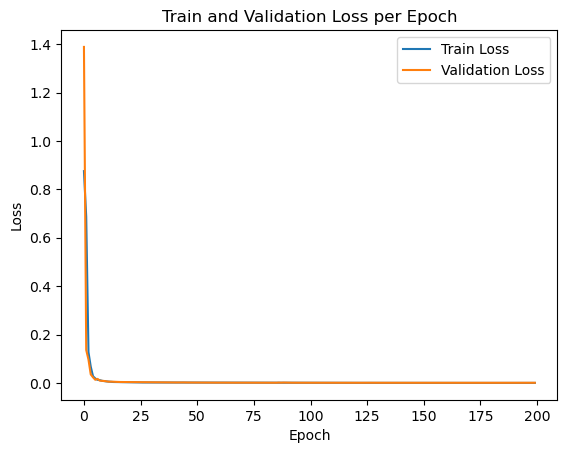

In [ ]:
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss per Epoch')
plt.savefig('train_val_loss_plot.png')
plt.show()


In [ ]:
# Test the model and save derained images
print('--- Testing starts! ---')
start_time_test = time.time()

unet.eval()
test_psnr = 0.0
test_ssim = 0.0
output_path = "G:\My Drive\Deraining\Rain100L\derained"
if not os.path.exists(output_path):
    os.makedirs(output_path)
metrics = []
with torch.no_grad():
    img_count = 1
    for i, (rain, norain) in enumerate(test_loader):
        rain = rain.to(device)
        norain = norain.to(device)

        output = unet(rain)
        output = output.cpu().numpy().transpose((0, 2, 3, 1)).clip(0, 1)
        norain = norain.cpu().numpy().transpose((0, 2, 3, 1)).clip(0, 1)

        for j in range(output.shape[0]):
            # Save the derained image
            output_img = Image.fromarray((output[j] * 255).astype(np.uint8))
            output_img.save(os.path.join(output_path, f"derained_{img_count}.png"))

            # Compute PSNR and SSIM
            cur_psnr = psnr(norain[j], output[j], data_range=1)
            cur_ssim = ssim(norain[j], output[j], data_range=1, multichannel=True)

            metrics.append([cur_psnr, cur_ssim])
            img_count += 1

# Save the metrics to a CSV file and compute the average and standard deviation
metrics_df = pd.DataFrame(metrics, columns=["PSNR", "SSIM"])
metrics_df.to_csv("metrics.csv", index=False)

mean_psnr = metrics_df["PSNR"].mean()
mean_ssim = metrics_df["SSIM"].mean()
std_psnr = metrics_df["PSNR"].std()
std_ssim = metrics_df["SSIM"].std()

print(f"Average PSNR: {mean_psnr:.6f} (std: {std_psnr:.6f}), Average SSIM: {mean_ssim:.6f} (std: {std_ssim:.6f})")

--- Testing starts! ---


C:\Users\labuser\AppData\Local\Temp\ipykernel_13276\1426726481.py:29: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  cur_ssim = ssim(norain[j], output[j], data_range=1, multichannel=True)


Average PSNR: 33.174186 (std: 1.710238), Average SSIM: 0.933454 (std: 0.039085)
